# Tutorial: Dask on TIKE
`Dask` is a powerful library for parallel computing in Python. By reading through code and compiling in into a "task graph," `Dask` efficiently organizes tasks and the sequence in which they need to be ordered. It can be used with a single, local machine to parallelize across whatever local cores are available. `Dask.distributed` extends the `Dask` framework to *distributed computing* on small to medium-sized clusters — which TIKE offers.

This notebook will walk users through the steps needed to optimally use the allocated resources.

## Package downloads

Our first step is to download the correct packages with the correct versions. Dask and its associated packages have gone through a number of major upgrades over the years, so this step is especially important to ensure that we are working with the package in the expected way.

Before we even do that, let's check the Python version we're on.

In [1]:
from platform import python_version

print(python_version())

3.11.11


If you started this notebook with the `TESS Environment`, the cell above likely printed out `3.11.11`. That's perfectly fine for many applications, of course. For our purposes, however, we'll want a specific Python version, one that plays nicely with the Dask packages that we'll later import. Let's install that Python version below. This step shouldn't take more than a couple of minutes.

In [2]:
!conda install python=3.11.7 -y

Retrieving notices: done
Channels:
 - conda-forge
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.0
    latest version: 25.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/conda/envs/tess

  added / updated specs:
    - python=3.11.7


The following NEW packages will be INSTALLED:

  liblzma-devel      conda-forge/linux-64::liblzma-devel-5.6.3-hb9d3cd8_1 
  xz                 conda-forge/linux-64::xz-5.6.3-hbcc6ac9_1 
  xz-gpl-tools       conda-forge/linux-64::xz-gpl-tools-5.6.3-hbcc6ac9_1 
  xz-tools           conda-forge/linux-64::xz-tools-5.6.3-hb9d3cd8_1 

The following packages will be UPDATED:

  ca-certificates    conda-forge/linux-64::ca-certificates~ --> conda-forge/noarch::ca-certificates-2025.4.26-hbd8a1cb_0 
  openssl                                  3.4.0-hb9d3cd8_0 --> 3.5.0-h7b32b05_1 

The following packages 

You'll need to restart the kernel for this change to go through. Run the cell below once you do so to make sure that you see `3.11.7`.

In [1]:
from platform import python_version

print(python_version())

3.11.7


Awesome! Assuming that worked, let's go ahead and import our packages. We'll do so with the `pip` package manager.

In [2]:
!pip install dask[dataframe]==2024.1.0 distributed==2024.1.0 msgpack==1.0.7 pandas==2.1.4 numpy==1.26.3 toolz==0.12.0 tornado==6.4 dask_gateway

  Using cached dask-2024.1.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached distributed-2024.1.0-py3-none-any.whl.metadata (3.4 kB)
  Using cached msgpack-1.0.7-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.1 kB)
  Using cached pandas-2.1.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached numpy-1.26.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached toolz-0.12.0-py3-none-any.whl.metadata (5.1 kB)
  Using cached tornado-6.4-cp38-abi3-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.5 kB)
  Using cached dask_gateway-2025.4.0-py3-none-any.whl.metadata (3.1 kB)
  Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached tblib-3.1.0-py3-none-any.whl.metadata (25 kB)
  Using cached zict-3.0.0-py2.py3-none-any.whl.metadata (899 bytes)
Using cached dask-2024.1.0-py3-none-any.whl (1.2 MB)
Using cached dist

With our packages installed, let's import them below.

In [16]:
import time

import astropy.units as u
import dask
import dask.array as da
# import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy 
from tqdm import tqdm

from astroquery.mast import Observations, Catalogs
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
from dask import delayed, compute
from dask.dataframe.utils import make_meta
from dask.diagnostics import ProgressBar  # Import the ProgressBar
from dask_gateway import Gateway, GatewayCluster
from distributed.diagnostics.plugin import PipInstall

# Import necessary libraries
import numpy as np
import os
import psutil
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from IPython.display import display, HTML

# Import Dask components
import dask
from dask.distributed import Client, performance_report, wait

from dask.distributed import performance_report

import time
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import psutil
import os
from dask_gateway import Gateway, GatewayCluster

import numpy as np
import pandas as pd
import os
import psutil
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from IPython.display import display, HTML

# Import Dask components
import dask
from dask.distributed import Client, performance_report, wait

# Setting up the Dask cluster

Next, we'll set up a *Dask Gateway*. A Gateway is a way to interact with Dask clusters, in particular the authentication and startup / shutdown components.

When instantiating the Gateway, we have to specify the *address* we'd like to point to (the dask-gateway server hosted by the TIKE team) and then how we'd like to authenticate. 

In [4]:
gateway = Gateway(address="http://traefik-dask-gateway", auth="jupyterhub")

This step essentially only creates configuration information. To assess whether everything's properly set up, we should actually interact with the Gateway --- for instance, by listing the clusters that we have access to. Let's see if there are any clusters open.

In [33]:
gateway.list_clusters()

[]

We've printed an empty list. Why? Because we haven't started up any clusters through this gateway yet!

Let's spin up a large cluster. We can do this with the `new_cluster` method, passing the `profile='cpu100'` argument to it. This asks Dask to create a cluster for us that has 100 available CPUs.

In [26]:
cluster = gateway.new_cluster(profile='cpu100')

Let's see what this cluster looks like. When we ask Jupyter to print it, a helpful UI will be rendered in the notebook. This graphic will be updated as resources are allocated toward and away from our cluster. *Note*: It's more performant to interact with this cluster programmatically instead of graphically. That is, don't click on the manual and adaptive scaling buttons below!

In [27]:
cluster

Our cluster doesn't have any workers or threads associated with it yet.  Again, this cluster has been initiated without any specified workers. To benefit from Dask's distributed computing strength, we'll need to specify how many workers the cluster should use and how they should be allocated. 

Let's fix that by asking the cluster to adapt between 2 and 3 workers.

In [28]:
# Adaptively scale between 2 and 3 workers
cluster.adapt(minimum=2, maximum=3)

/opt/conda/envs/tess/lib/python3.11/site-packages/dask_gateway/client.py:702: GatewayWarning: Adapt with `maximum=3, minimum=2` workers would exceed resource limit of 1 workers. Using `maximum=1, minimum=1` instead.
  warnings.warn(GatewayWarning(msg["msg"]))


We'll get a message that our cluster cannot allocate more than 1 worker above. That's by design — the cluster that we requested has 95 threads and 1 worker, without flexibility.

It can take a few minutes for the cluster resources to be allocated.

Once the cluster is set up, we can set up a client. The client allows us to explicitly interact with the cluster. 

[todo: explain more?]

In [13]:
client = cluster.get_client()
client

/opt/conda/envs/tess/lib/python3.11/site-packages/distributed/client.py:1391: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | Client | Scheduler | Workers |
+---------+--------+-----------+---------+
| tornado | 6.4.1  | 6.4       | 6.4     |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: http://traefik-dask-gateway/clusters/default.592c7ec4b8144a59a5b7e0f664021e11/status,


2025-05-22 02:24:35,260 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


When we look at the client, we should immediately get a warning about a version mismatch between the client and the scheduler. This essentially means that the workers and the local version of Python that we're working with through the notebook have different versions, which can lead to confusion as Dask attempts to schedule tasks.

Luckily, this is easily fixed. All we have to do is "register" the package. This essentially installs a package version on the client side.

In [15]:
plugin = PipInstall(packages=[
    "tornado==6.4.1"
])

# essentially pip installs the package on the cluster
client.register_plugin(plugin)

# Benchmarking Dask

We have everything set up. Let's work on a test problem now. We'll set a CPU-intensive task that essentially performs matrix operations. We'll leave the function modular enough so that you can implement your own benchmarks as you see fit.

Note that our benchmarking function (`cpu_intensive_task`) is a relatively normal function. It uses Python libraries, instantiates some arrays, and performs operations on those arrays. Importantly, very call to this function (specified by `cpu_intensive_task`) can be performed independently, so we can pass this function to `client.map` (which is analagous to Python's builtin `map` function).

In [17]:
def cpu_intensive_task(task_id, matrix_size=1000, iterations=20):
    """A CPU-intensive task that performs matrix operations repeatedly."""
    start_time = time.time()
    
    # Create random matrices
    matrix_a = np.random.random((matrix_size, matrix_size))
    matrix_b = np.random.random((matrix_size, matrix_size))
    
    # Perform multiple matrix operations to simulate CPU-intensive work
    result = np.identity(matrix_size)
    for i in range(iterations):
        # Mix of operations to stress different CPU aspects
        if i % 3 == 0:
            result = np.matmul(result, matrix_a)
        elif i % 3 == 1:
            result = np.matmul(result, matrix_b)
        else:
            # Element-wise operations
            temp = np.sin(matrix_a) + np.cos(matrix_b)
            result = result + temp
            
        # Add some scalar operations
        result = result * 0.9999
    
    # Force some memory pressure with intermediate results
    intermediate_results = []
    for i in range(3):
        intermediate_results.append(result + np.random.random((matrix_size, matrix_size)) * 0.001)
    
    # Calculate some statistics to ensure work isn't optimized away
    stats = {
        'mean': float(np.mean(result)),
        'std': float(np.std(result)),
        'min': float(np.min(result)),
        'max': float(np.max(result)),
        'task_id': task_id,
        'duration': time.time() - start_time
    }
    
    return stats


# Simple function to run the benchmark in a notebook
def run_benchmark(client, task_type='cpu', num_tasks=100, matrix_size=1000, iterations=20):
    """Run a benchmark with the specified parameters using client.map"""
    
    print(f"Starting Dask benchmark with {num_tasks} {task_type} tasks")
    print(f"Connected to Dask cluster: {client.dashboard_link}")
    
    # Display system information
    print("\n--- System Information ---")
    print(f"CPU cores: {psutil.cpu_count(logical=False)} physical, {psutil.cpu_count(logical=True)} logical")
    print(f"Memory: {psutil.virtual_memory().total / (1024**3):.1f} GB total")
    
    # Get cluster information and number of workers
    workers_info = client.scheduler_info()['workers']
    num_workers = len(workers_info)
    print(f"Number of workers: {num_workers}")
    
    # Prepare task arguments based on the task type
    if task_type == 'cpu':
        task_args = [(i, matrix_size, iterations) for i in range(num_tasks)]
        args_transposed = list(zip(*task_args))
        
        # Start the benchmark
        print("Submitting tasks using client.map...")
        start_time = time.time()
        
        # Use client.map to submit all tasks at once
        futures = client.map(cpu_intensive_task, *args_transposed)
        
    else:
        raise ValueError(f"Unknown task type: {task_type}. Perhaps it needs to be implemented!")
    
    # Wait for tasks to complete - show progress
    total_tasks = len(futures)
    print(f"Waiting for {total_tasks} tasks to complete...")
    
    # Track progress
    def print_progress(futures):
        completed = sum(f.done() for f in futures)
        print(f"Completed: {completed}/{total_tasks} tasks ({completed/total_tasks*100:.1f}%)")
    
    # Wait for all futures to complete
    while not all(f.done() for f in futures):
        print_progress(futures)
        time.sleep(2)
    
    # Gather results
    print("Gathering results...")
    results = client.gather(futures)
    
    total_duration = time.time() - start_time
    print(f"Benchmark completed in {total_duration:.2f} seconds")
    
    # Convert results to DataFrame
    df = pd.DataFrame(results)
    df['task_type'] = task_type
    
    # Show some basic analysis
    print("\n--- Benchmark Analysis ---")
    print(f"Total execution time: {total_duration:.2f} seconds")
    
    # Calculate statistics
    task_stats = df.groupby('task_type')['duration'].agg(['count', 'mean', 'std', 'min', 'max'])
    display(HTML("<h3>Task Statistics</h3>"))
    display(task_stats)
    
    # Calculate throughput
    tasks_per_second = total_tasks / total_duration
    tasks_per_worker_second = tasks_per_second / num_workers if num_workers > 0 else 0
    
    print(f"\nThroughput:")
    print(f"- Total tasks: {total_tasks}")
    print(f"- Tasks per second: {tasks_per_second:.2f}")
    print(f"- Tasks per worker per second: {tasks_per_worker_second:.2f}")
    
    # Plot a histogram of task durations
    plt.figure(figsize=(10, 6))
    sns.histplot(df['duration'], kde=True)
    plt.title(f'Distribution of {task_type.upper()} Task Durations')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Count')
    plt.show()
    
    return df, total_duration




Now, let's run our benchmark function. We'll wrap our benchmark function in a call to `performance_report`. Doing so will have the side effect of producing a useful html file summarizing our Dask cluster usage.

Starting Dask benchmark with 100 cpu tasks
Connected to Dask cluster: http://traefik-dask-gateway/clusters/default.592c7ec4b8144a59a5b7e0f664021e11/status

--- System Information ---
CPU cores: 1 physical, 2 logical
Memory: 7.6 GB total
Number of workers: 1
Submitting tasks using client.map...
Waiting for 100 tasks to complete...
Completed: 0/100 tasks (0.0%)
Completed: 0/100 tasks (0.0%)
Completed: 0/100 tasks (0.0%)
Gathering results...
Benchmark completed in 6.04 seconds

--- Benchmark Analysis ---
Total execution time: 6.04 seconds


,count,mean,std,min,max
task_type,,,,,
cpu,100,4.905248,0.902378,1.083764,5.58437



Throughput:
- Total tasks: 100
- Tasks per second: 16.56
- Tasks per worker per second: 16.56


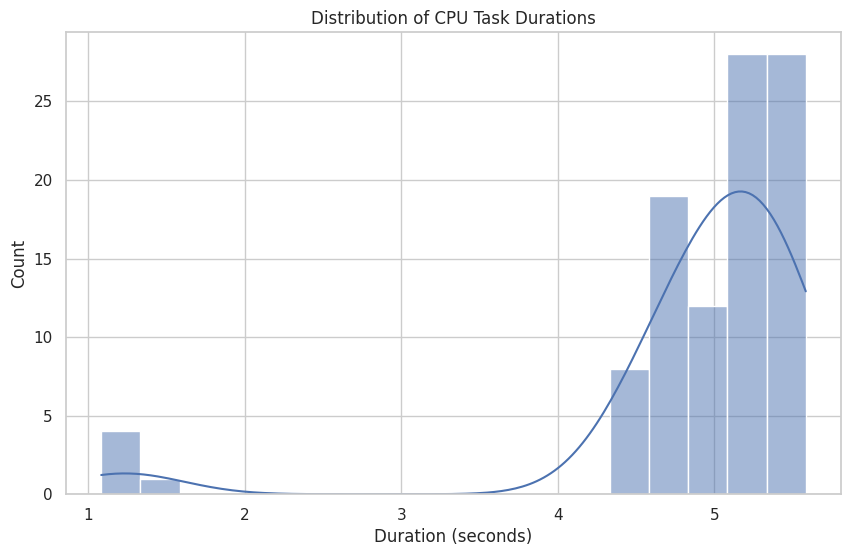

In [18]:
with performance_report(filename="dask-report_existing_client.html"):
    with dask.config.set(scheduler='distributed'):
        
        # Run the benchmark
        results, duration = run_benchmark(
            client=client,
            task_type='cpu',
            num_tasks=100,
            matrix_size=1000,
            iterations=20
        )

The plot shown here provides some intuition regarding the computation. Most tasks took somewhere between 4 and 5 seconds, whereas others were completed much more quickly. 

We can access much more granularity regarding these computations (e.g., memory and CPU consumption) by inspecting the HTML file that we output. Mouse over to the filer browser to your left and double-click on `dask-report_existing_client.html`. You'll need to verify that you trust the file (you probably should, given that you just generated it!). The first tab will present you with a simple summary of the computation, including the code block that called the performance report, how many tasks were submitted to Dask, and how long the computation took. The `system` tab is particularly useful, as it shows how much CPU, memory, and bandwidth were used over the course of the Dask calculation.

That calculation seems pretty fast. Exactly how fast, though? Let's compare that runtime to that of a smaller cluster. First, let's clean up our workspace by shutting down the cluster. This is really important — it ensures that TIKE doesn't use unnecessary resources!

In [42]:
cluster.shutdown()

We can check that this worked correctly by again listing the clusters associated with our gateway.

In [43]:
gateway.list_clusters()

[]

Great, an empty list! Now, we can spin up another cluster without passing the `cpu100` profile.

In [36]:
cluster = gateway.new_cluster()
cluster

We can once again ask for some number of workers.

In [37]:
# Adaptively scale between 2 and 3 workers
cluster.adapt(minimum=2, maximum=3)

Note that we didn't get a warning this time, because we didn't specifically request the cluster option that allows 100 CPUs.

Let's get our cluster once again.

In [38]:
client = cluster.get_client()
client

/opt/conda/envs/tess/lib/python3.11/site-packages/distributed/client.py:1391: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | Client | Scheduler | Workers |
+---------+--------+-----------+---------+
| tornado | 6.4.1  | 6.4       | None    |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: http://traefik-dask-gateway/clusters/default.2f57d458961e4231b55ff9c80b8b5e65/status,


In [39]:
plugin = PipInstall(packages=[
    "tornado==6.4.1"
])
client.register_plugin(plugin)

Once the cluster UI indicates that our requested workers are ready, we can once again try our benchmark, passing the new client corresponding to the new cluster. This time, as the code runs, watch the number of workers and threads might change. This means Dask is working as expected — it's dynamically scaling up the resources available to us from the broader TIKE CPU pool based on the amount of work we're currently requesting to complete. Neat!

Starting Dask benchmark with 100 cpu tasks
Connected to Dask cluster: http://traefik-dask-gateway/clusters/default.2f57d458961e4231b55ff9c80b8b5e65/status

--- System Information ---
CPU cores: 1 physical, 2 logical
Memory: 7.6 GB total
Number of workers: 1
Submitting tasks using client.map...
Waiting for 100 tasks to complete...
Completed: 0/100 tasks (0.0%)
Completed: 3/100 tasks (3.0%)
Completed: 9/100 tasks (9.0%)
Completed: 14/100 tasks (14.0%)
Completed: 19/100 tasks (19.0%)
Completed: 24/100 tasks (24.0%)
Completed: 29/100 tasks (29.0%)
Completed: 35/100 tasks (35.0%)
Completed: 40/100 tasks (40.0%)
Completed: 45/100 tasks (45.0%)
Completed: 51/100 tasks (51.0%)
Completed: 57/100 tasks (57.0%)
Completed: 60/100 tasks (60.0%)
Completed: 66/100 tasks (66.0%)
Completed: 71/100 tasks (71.0%)
Completed: 75/100 tasks (75.0%)
Completed: 81/100 tasks (81.0%)
Completed: 87/100 tasks (87.0%)
Completed: 92/100 tasks (92.0%)
Gathering results...
Benchmark completed in 38.05 seconds

--- Ben

,count,mean,std,min,max
task_type,,,,,
cpu,100,1.163201,0.106782,0.814741,1.543228



Throughput:
- Total tasks: 100
- Tasks per second: 2.63
- Tasks per worker per second: 2.63


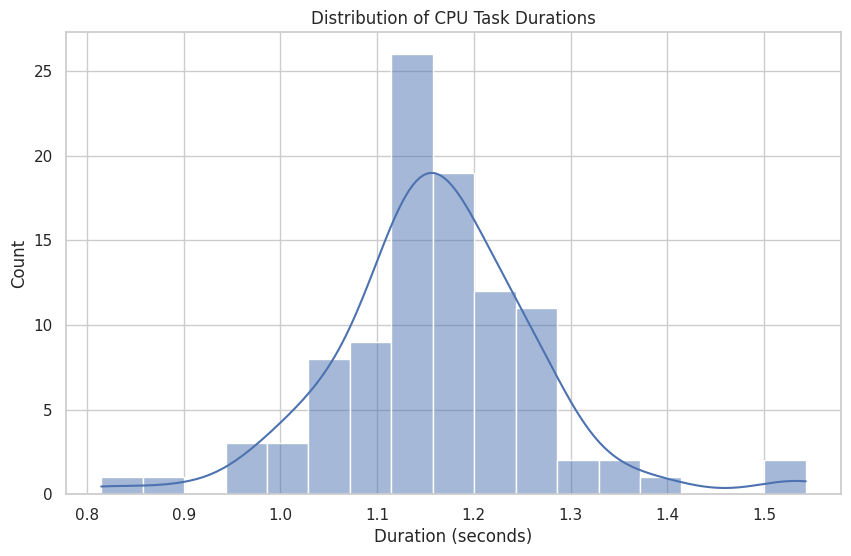

In [40]:
with performance_report(filename="dask-report_existing_client_smaller.html"):
    with dask.config.set(scheduler='distributed'):
        
        # Run the benchmark
        results, duration = run_benchmark(
            client=client,
            task_type='cpu',
            num_tasks=100,
            matrix_size=1000,
            iterations=20
        )

OK, that's definitely slower than the `cpu100` option, but the math seems fishy. When running the above cell, you might see utilization of anywhere between 3 and 12 CPU (multiplying workers and threads), but slowdowns of only 3-6x. Why is that?

For tasks that individually are short or require limited computaitonal resources, the human-recorded (wall) time speedup will be modest. This is because Dask incurs some overhead when it's figuring out what tasks have been asked of it and how to allocate those tasks to individual workers (i.e., when optimizing how best to parallelize the work provided).

Feel free to see how this scales if, e.g., you increase the matrix size to 5000. You should expect the speedup factor to approach 10 in those cases that are purely CPU-bound.

Again, once you're done with your cluster, make sure to shut it down!

In [41]:
cluster.shutdown()

# Resources
- `Dask.distributed documentation:  https://distributed.dask.org/en/stable/index.html
- General Dask documentation: https://docs.dask.org/en/stable/